# Stroke Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import chi2_contingency
from scipy.stats import spearmanr

import warnings
warnings.filterwarnings('ignore')

***We are going to analyze this dataset from Kaggle. We are trying to come up with the key insights and recommendations for the Healthcare department and Insurance Company to help them understand and take measures to prevent stroke. According to Kaggle: 'This dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status.'*** 

In [2]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [3]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [5]:
# data cleaning

#drop the useless col
df.drop('id', axis=1, inplace=True)

# fill NaN with mean in df['bmi']
bmi_mean = df['bmi'].mean()
df['bmi'].fillna(bmi_mean, inplace=True)

# convert age column into int
df['age'] = df['age'].astype(int)

# check if changes are made
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   int64  
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                5110 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 439.3+ KB


## What is the age group distribution of the patients?

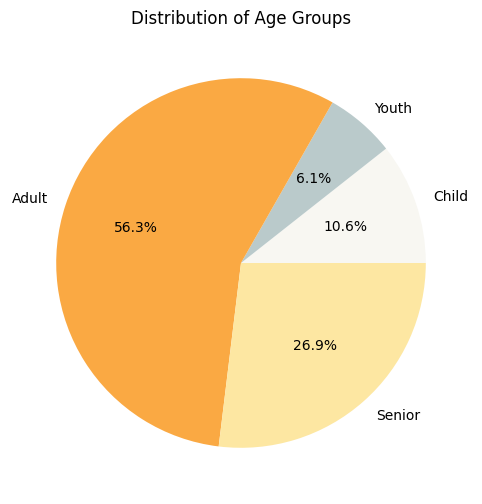

In [6]:
# define age group and label them
bins = [0, 12, 18, 60, 100]  
labels = ['Child', 'Youth', 'Adult', 'Senior']  
# use cut() to group them
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

# generate a series to count portion size
age_group_counts = df['age_group'].value_counts(sort=False)
plt.figure(figsize=(8, 6))
plt.pie(age_group_counts, labels=age_group_counts.index, autopct='%1.1f%%',  colors=['#F8F7F2','#BACACB','#FAA943','#FDE7A2'])
plt.title('Distribution of Age Groups')
plt.show()

**In this dataset, adult is the largest group.**

## What are the rates of hypertension and heart disease among different genders?

In [7]:
# data on df['gender']=='other'
other_row = df[df['gender'] == 'Other']
other_row

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_group
3116,Other,26,0,0,No,Private,Rural,143.33,22.4,formerly smoked,0,Adult


In [8]:
#temporarily remove the 'Other' row because it only consists of one entry and is irrelevant to my study of hypertension and heart disease.
temp_df = df[df['gender'] != 'Other']

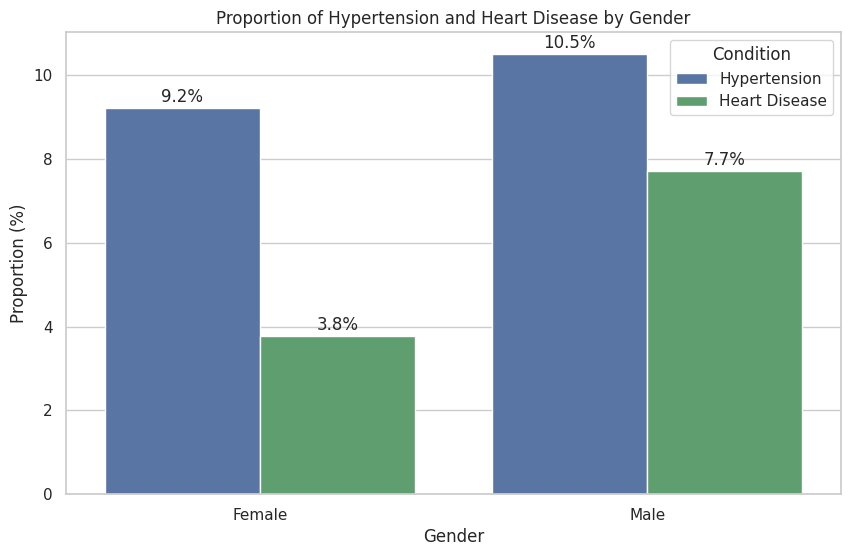

In [9]:
# calculate total number by gender who had hypertension or heart disease
gender_counts = temp_df.groupby('gender').size()

# calculate hypertension rate
hypertension_counts = temp_df.groupby(['gender','hypertension']).size().unstack()
hypertension_rates = (hypertension_counts[1]/gender_counts) * 100

# calculate heart disease rate
heart_disease_counts = temp_df.groupby(['gender','heart_disease']).size().unstack()
heart_disease_rates = (heart_disease_counts[1]/gender_counts) * 100

# create new DataFrame to store rates
proportion_df = pd.DataFrame({
    'Hypertension': hypertension_rates,
    'Heart Disease': heart_disease_rates
}).reset_index()
# print(proportion_df)

# set plotting style
sns.set(style="whitegrid")

# grouped barplot
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='gender', y='value', hue='variable', 
                      data=proportion_df.melt(id_vars='gender'), palette=['#4c72b0', '#55a868'])

# add label
for p in barplot.patches:
    if p.get_height() > 0.1: # debug the '0.0' appear in the wrong place
        barplot.annotate(format(p.get_height(), '.1f')+ '%', 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha = 'center', va = 'center', 
                         xytext = (0, 8), 
                         textcoords = 'offset points')
plt.xlabel('Gender')
plt.ylabel('Proportion (%)')
plt.title('Proportion of Hypertension and Heart Disease by Gender')
plt.legend(title='Condition')
plt.show()

**The prevalence of Hypertension among genders are similar but the prevalence of heart disease among genders are different, male are easier to have heart disease than female.**

## How does gender affect the incidence of stroke?

In [10]:
# calculate gender rate
gender_stroke_counts = temp_df.groupby(['gender','stroke']).size().unstack()
print(gender_stroke_counts)
gender_stroke_rates = (gender_stroke_counts[1]/gender_counts) * 100
gender_stroke_rates

stroke     0    1
gender           
Female  2853  141
Male    2007  108


gender
Female    4.709419
Male      5.106383
dtype: float64

**There are slightly more male stroke cases than female cases.**

## How does gender and marital status affect the incidence of stroke?

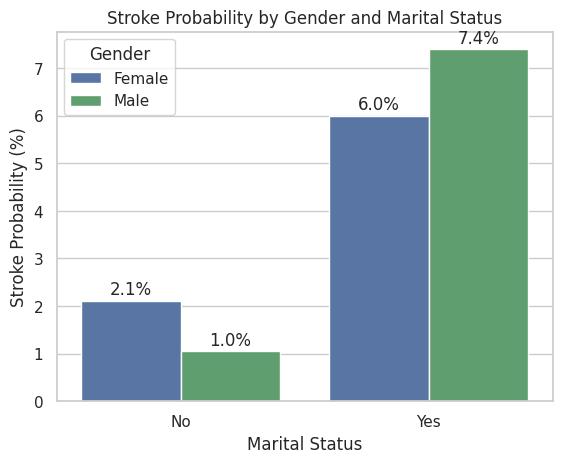

In [11]:
# calculate total number by marital status who had strokes
total_counts = temp_df.groupby(['gender','ever_married']).size()

# calculate marital status and gender stoke rates
stroke_counts = temp_df[temp_df['stroke']==1].groupby(['gender','ever_married']).size()

#calculate stroke probabilities
stroke_probabilities = (stroke_counts/total_counts) * 100

# create new DataFrame to store rates
stroke_probabilities_df = stroke_probabilities.reset_index(name='stroke_probability')

# set plotting style
sns.set(style="whitegrid")
barplot = sns.barplot(data=stroke_probabilities_df, x='ever_married', y='stroke_probability', hue='gender', palette=['#4c72b0', '#55a868'])

# add label
for p in barplot.patches:
    if p.get_height() > 0.1: # debug the '0.0' appear in the wrong place
        barplot.annotate(format(p.get_height(), '.1f') + '%', 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha = 'center', va = 'center', 
                         xytext = (0, 8), 
                         textcoords = 'offset points')
plt.xlabel('Marital Status')
plt.ylabel('Stroke Probability (%)')
plt.title('Stroke Probability by Gender and Marital Status')
plt.legend(title='Gender')
plt.show()

**Married people are easier to have stroke than unmarried people, before marriage male are less likely to have strokes but after marriage they are more likely to have strokes.**

## How do the average glucose levels and body mass index (BMI) differ between urban and rural patients?

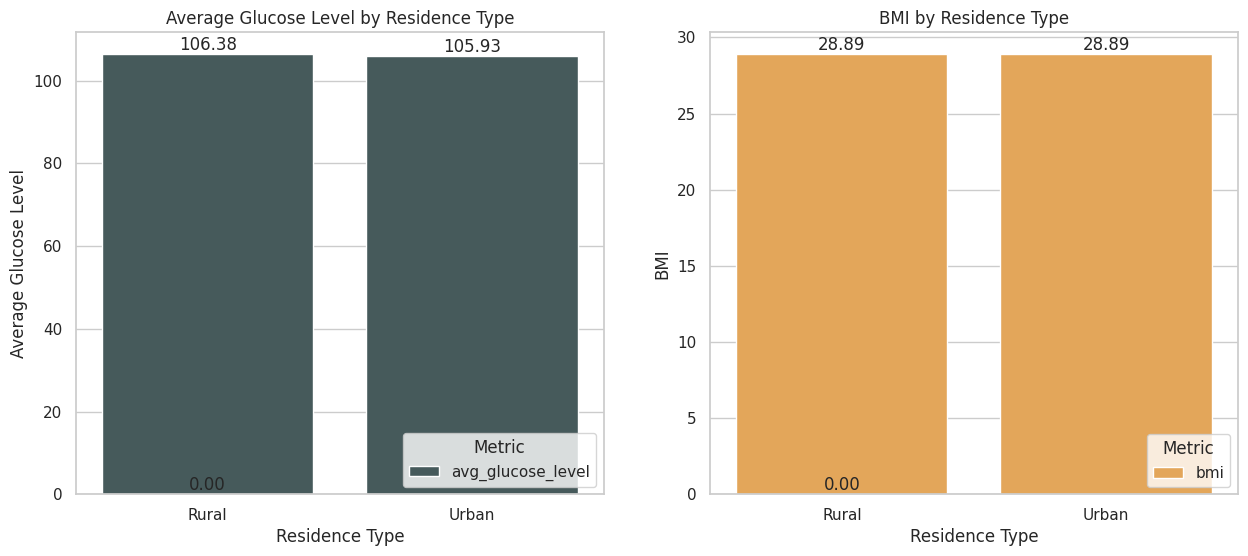

In [12]:
# group by avg_glucose_level and bmi, then get mean value
grouped = df.groupby('Residence_type')[['avg_glucose_level', 'bmi']].mean().reset_index()

# convert a DataFrame from wide format to long format.
melted_df = grouped.melt(id_vars='Residence_type', var_name='Metric', value_name='Value')

# visulization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# subplot1： average glucose level
sns.barplot(data=melted_df[melted_df['Metric'] == 'avg_glucose_level'], 
            x='Residence_type', y='Value', hue='Metric', palette=['#425d5f'], ax=ax1)
ax1.set_title('Average Glucose Level by Residence Type')
ax1.set_xlabel('Residence Type')
ax1.set_ylabel('Average Glucose Level')
ax1.legend(title='Metric', loc='lower right')

# add label
for p in ax1.patches:
    ax1.annotate(format(p.get_height(), '.2f'), 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='bottom')

# subplot2: BMI
sns.barplot(data=melted_df[melted_df['Metric'] == 'bmi'], 
            x='Residence_type', y='Value', hue='Metric', palette=['#faa943'], ax=ax2)
ax2.set_title('BMI by Residence Type')
ax2.set_xlabel('Residence Type')
ax2.set_ylabel('BMI')
ax2.legend(title='Metric', loc='lower right')

# add label
for p in ax2.patches:
    ax2.annotate(format(p.get_height(), '.2f'), 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='bottom')
plt.show()

**The data shows that the average glucose levels and BMI index of urban and rural people are very similar, with average glucose levels around 106(within normal range). However, the average BMI is close to 29, which indicates overweight.**

## How will different BMI affect the incidence of stroke?

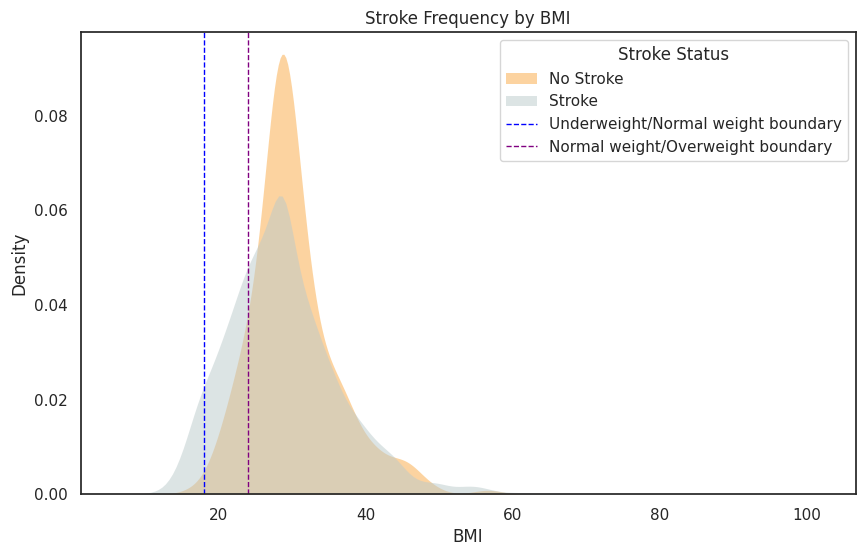

In [13]:
# set plot style
sns.set(style="white")
plt.figure(figsize=(10, 6))

# kdeplot 
sns.kdeplot(data=df, x="bmi", hue="stroke", fill=True, common_norm=False, palette=['#bacacb','#faa943'], alpha=.5, linewidth=0)
plt.xlabel('BMI')
plt.ylabel('Density')
plt.title('Stroke Frequency by BMI')

# plot avxline to show BMI range 
plt.axvline(x=18, color='blue', linestyle='--', linewidth=1, label='Underweight/Normal weight boundary')
plt.axvline(x=24, color='purple', linestyle='--', linewidth=1, label='Normal weight/Overweight boundary')
plt.legend(title='Stroke Status', labels=['No Stroke', 'Stroke', 'Underweight/Normal weight boundary', 'Normal weight/Overweight boundary'])
plt.show()

In [14]:
# define bmi group and label them
bins = [0, 18, 24, 100]  
labels = ['Underweight', 'Normal weight', 'Overweight']  
df['bmi_group'] = pd.cut(df['bmi'], bins=bins, labels=labels, right=False)
bmi_stroke_counts = df.groupby(['bmi_group', 'stroke']).size().unstack(fill_value=0)
bmi_stroke_counts['Stroke Rate (%)'] = bmi_stroke_counts[1]/(bmi_stroke_counts[0]+bmi_stroke_counts[1])*100
bmi_stroke_counts

stroke,0,1,Stroke Rate (%)
bmi_group,,,
Underweight,272,1,0.366300
Normal weight,1020,25,2.392344
Overweight,3569,223,5.880802


**Compared to other weight groups, the proportion of strokes is significantly higher in the overweight group. This result may suggest that individuals with higher BMI are more likely to experience strokes.**

## What is the relationship between smoking status and stroke incidence?

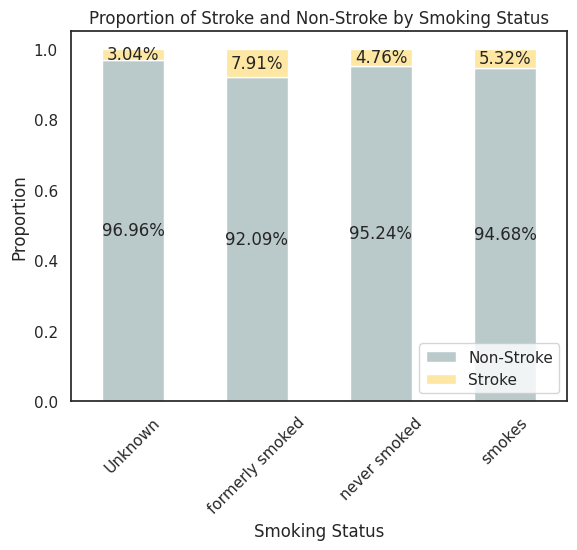

In [15]:
# count peopke with different smoking status, their stroke experience
stroke_counts = df.groupby(['smoking_status', 'stroke']).size().unstack(fill_value=0)

# total number of different smoking status
total_counts = stroke_counts.sum(axis=1)

# calculate stroke ratios
stroke_ratios = stroke_counts.div(total_counts, axis=0)

# plot Stacked Bar Chart 
stroke_ratios.plot(kind='bar', stacked=True, color=['#BACACB', '#FDE7A2'])
plt.xlabel('Smoking Status')
plt.ylabel('Proportion')
plt.title('Proportion of Stroke and Non-Stroke by Smoking Status')
plt.xticks(rotation=45)
plt.legend(['Non-Stroke', 'Stroke'], loc='lower right')

# add label
for idx, rect in enumerate(plt.gca().patches):
    height = rect.get_height()
    if height > 0:  
        plt.gca().text(rect.get_x() + rect.get_width() / 2., rect.get_y() + height / 2.,
                       f'{height:.2%}', ha='center', va='center')
plt.show()

**Individuals who formerly smoked and currently smoke have higher stroke rates, especially those who formerly smoked. This suggests that even after quitting smoking, the risk of stroke may still persist.**

## Does age affect the incidence of stroke?

In [16]:
'''
Null Hypothesis (H0): Age doesn't affect the incidence of stroke.
Alternative Hypothesis (H1): Age affects the incidence of stroke.
Use Logistic Regression
    The dependent variable is binary (e.g., whether a stroke occurred).
    Continuous variables (age).
'''
import statsmodels.api as sm

X = df['age']  
y = df['stroke']  
X = sm.add_constant(X)  # add constant
model = sm.Logit(y, X).fit()  # create model
print(model.summary())  

Optimization terminated successfully.
         Current function value: 0.158150
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                 stroke   No. Observations:                 5110
Model:                          Logit   Df Residuals:                     5108
Method:                           MLE   Df Model:                            1
Date:                Thu, 01 Aug 2024   Pseudo R-squ.:                  0.1879
Time:                        14:40:24   Log-Likelihood:                -808.15
converged:                       True   LL-Null:                       -995.19
Covariance Type:            nonrobust   LLR p-value:                 2.426e-83
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.2306      0.335    -21.585      0.000      -7.887      -6.574
age            0.0747      0.

**P-value is lower than alpha(0.05). So, we reject the null hypothesis. The results indicate that age is significantly associated with the likelihood of having a stroke. Specifically, the coefficient for age is 0.0747, meaning that for each additional year of age, the log odds of having a stroke increase by approximately 0.0747. With a pseudo R-squared value of 0.1879, indicating that age provides a certain level of explanatory power for the occurrence of stroke.**

## Is the residence type(City vs. Rural) affect the incidence of stroke?

In [17]:
'''
Null Hypothesis (H0): The residence type doesn't affect the incidence of stroke.
Alternative Hypothesis (H1): The residence type affects the incidence of stroke.
Decide to use Chi-square test because the two variables are the residence type (urban vs. rural) and the presence of hypertension (yes or no), they are categorical variables.
'''
# Create a contingency table
contingency_table = pd.crosstab(df['stroke'], df['Residence_type'])
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
print('chi2 =',chi2)
print('p =',p)
print('dof =',dof)
print('expected =',expected)

alpha = 0.05

# evaluate
if p < alpha:
    print("Reject null hypothesis. The residence type affects the incidence of stroke.")
else:
    print("Fail to reject null hypothesis. The residence type doesn't affect the incidence of stroke.")

chi2 = 1.0816367471627524
p = 0.29833169286876987
dof = 1
expected = [[2391.49784736 2469.50215264]
 [ 122.50215264  126.49784736]]
Fail to reject null hypothesis. The residence type doesn't affect the incidence of stroke.


**Residence type doesn't affect the incidence of the stroke.**

## Is there a significant relationship between medical history (such as hypertension and heart disease) and the occurrence of stroke?

In [18]:
'''
Null Hypothesis (H0): There is no significant relationship between medical history (such as hypertension and heart disease) and the occurrence of stroke.
Alternative Hypothesis (H1): There is a significant relationship between medical history (such as hypertension and heart disease) and the occurrence of stroke.
Decide to use Chi-square test for the two categorical variables (medical history and stroke).
'''
# create a new col represent patients had both conditions(hypertension and heart disease)
df['both_conditions'] = (df['hypertension'] == 1) & (df['heart_disease'] == 1)

# turn boolean into 0 & 1
df['both_conditions'] = df['both_conditions'].astype(int)

variables = {
    'hypertension': 'Hypertension',
    'heart_disease': 'Heart Disease',
    'both_conditions': 'Both Conditions'
}

for var, var_name in variables.items():
    contingency_table = pd.crosstab(df[var], df['stroke'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"Results for {var_name}:")
    print(f"Chi-square statistic = {chi2:.4f}, p-value = {p:.4f}, degrees of freedom = {dof}")
    alpha = 0.05
    if p < alpha:
        print("Reject null hyphothesis. There is a statistically significant relationship between", var_name, "and stroke.\n")
    else:
        print("Fail to reject null hypothesis. There is no statistically significant relationship between", var_name, "and stroke.\n")

Results for Hypertension:
Chi-square statistic = 81.6054, p-value = 0.0000, degrees of freedom = 1
Reject null hyphothesis. There is a statistically significant relationship between Hypertension and stroke.

Results for Heart Disease:
Chi-square statistic = 90.2596, p-value = 0.0000, degrees of freedom = 1
Reject null hyphothesis. There is a statistically significant relationship between Heart Disease and stroke.

Results for Both Conditions:
Chi-square statistic = 30.0432, p-value = 0.0000, degrees of freedom = 1
Reject null hyphothesis. There is a statistically significant relationship between Both Conditions and stroke.



In [19]:
stroke_rates = df.groupby(['hypertension', 'heart_disease', 'both_conditions'])['stroke'].mean().reset_index()
stroke_rates['stroke'] = stroke_rates['stroke'] * 100  
stroke_rates.columns = ['Hypertension', 'Heart Disease', 'Both Conditions', 'Stroke Rate (%)']
print(stroke_rates)

   Hypertension  Heart Disease  Both Conditions  Stroke Rate (%)
0             0              0                0         3.386364
1             0              1                0        16.037736
2             1              0                0        12.211982
3             1              1                1        20.312500


**Patients without a history of hypertension or heart disease have the lowest probability of experiencing a stroke. In contrast, those with a history of either hypertension or heart disease alone have a higher stroke rate, while the highest stroke rate is observed in patients with both conditions. This indicates a strong association between stroke incidence and medical history.**

## Is there correlation among age, avg_glucose_level and BMI?

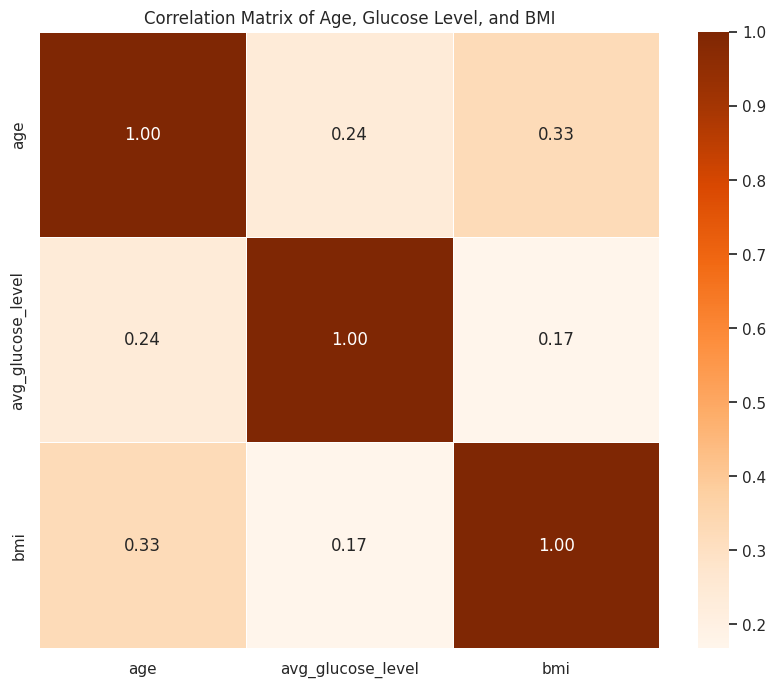

In [20]:
# calculate correlation matrix
correlation_matrix = df[['age', 'avg_glucose_level', 'bmi']].corr()

# plot heatmap to observe
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Oranges', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Age, Glucose Level, and BMI')
plt.show()

- **Age and Avg_glucose_level (0.24)**: A moderate positive correlation between age and average glucose levels, suggesting that older people's average glucose levels may tend to increase. 
- **Age and BMI (0.33)**: A moderate correlation suggests that BMI may also tend to increase with age. This could be related to decreases in metabolic rate and physical activity as people get older, which often contribute to weight gain over the years.
- **Avg_glucose_level and BMI (0.17)**: The correlation is weaker, suggests that higher glucose levels might be associated with higher BMI. This relationship can be linked to insulin resistance, which is more prevalent in individuals with higher BMI. Insulin resistance often leads to higher glucose levels as the body becomes less efficient at managing sugar.

In [21]:
# calculate nomarlity to decide using Pearson's r or Spearman's Rank Correlation
variables = ['age', 'avg_glucose_level', 'bmi']

for i in range(len(variables)):
    for j in range(i + 1, len(variables)):
        data1 = df[variables[i]]
        data2 = df[variables[j]]

        # shapiro test 
        _, p1 = stats.shapiro(data1)
        _, p2 = stats.shapiro(data2)

        if p1 > 0.05 and p2 > 0.05:
            corr_coef, p_value = stats.pearsonr(data1, data2)
            print(f"Pearson correlation between {variables[i]} and {variables[j]}: r = {corr_coef}, p = {p_value}")
        else:
            corr_coef, p_value = stats.spearmanr(data1, data2)
            print(f"Spearman rank correlation between {variables[i]} and {variables[j]}: rho = {corr_coef}, p = {p_value}")

Spearman rank correlation between age and avg_glucose_level: rho = 0.14516084876669988, p = 1.8191575722784894e-25
Spearman rank correlation between age and bmi: rho = 0.3636577444717609, p = 1.413520691099459e-159
Spearman rank correlation between avg_glucose_level and bmi: rho = 0.11369630776085582, p = 3.580912687123695e-16


## What are the Spearman rank correlation coefficients between age, average glucose level, and BMI, and what do these coefficients tell us about the relationships between these variables?

### Correlation between age and average glucose level.

In [22]:
'''
Null Hypothesis (H0): There is no monotonic relationship between age and average glucose level. (ρ=0)
Alternative Hypothesis (H1): There is a monotonic relationship between age and average glucose level. (ρ!=0)
'''
from scipy.stats import spearmanr

age = df['age']
avg_glucose_level = df['avg_glucose_level']

spearman_corr, p_value = spearmanr(age, avg_glucose_level)

print(f"Spearman rank correlation coefficient between age and average glucose level: {spearman_corr}")
print(f"p-value: {p_value}")

alpha = 0.05

# evaluate
if p_value < alpha:
    print("Reject null hypothesis. There is a statistically significant monotonic relationship between age and average glucose level.")
else:
    print("Fail to reject null hypothesis. There is no statistically significant monotonic relationship between age and average glucose level.")

Spearman rank correlation coefficient between age and average glucose level: 0.14516084876669988
p-value: 1.8191575722784894e-25
Reject null hypothesis. There is a statistically significant monotonic relationship between age and average glucose level.


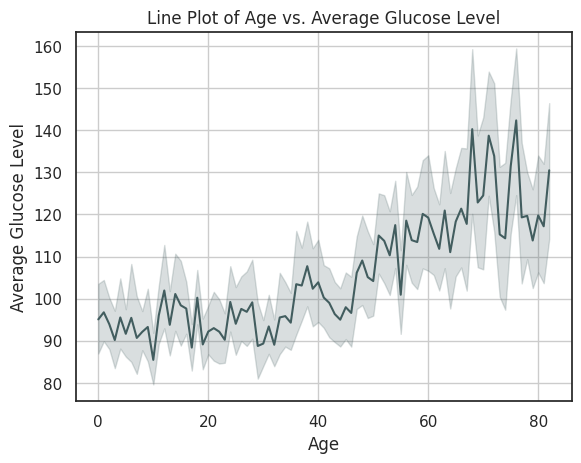

In [23]:
#line plot
sns.lineplot(x=age, y=avg_glucose_level, color='#425d5f')
plt.title('Line Plot of Age vs. Average Glucose Level')  
plt.xlabel('Age')  
plt.ylabel('Average Glucose Level')  
plt.grid(True)  
plt.show()  

### Correlation between age and bmi.

In [24]:
'''
Null Hypothesis (H0): There is no monotonic relationship between age and bmi. (ρ=0)
Alternative Hypothesis (H1): There is a monotonic relationship between age and bmi. (ρ!=0)
'''
age = df['age']
bmi = df['bmi']

spearman_corr, p_value = spearmanr(age, bmi)

print(f"Spearman rank correlation coefficient between age and bmi: {spearman_corr}")
print(f"p-value: {p_value}")

alpha = 0.05

# evaluate
if p_value < alpha:
    print("Reject null hypothesis. There is a statistically significant monotonic relationship between age and bmi.")
else:
    print("Fail to reject null hypothesis. There is no statistically significant monotonic relationship between age and bmi.")

Spearman rank correlation coefficient between age and bmi: 0.3636577444717609
p-value: 1.413520691099459e-159
Reject null hypothesis. There is a statistically significant monotonic relationship between age and bmi.


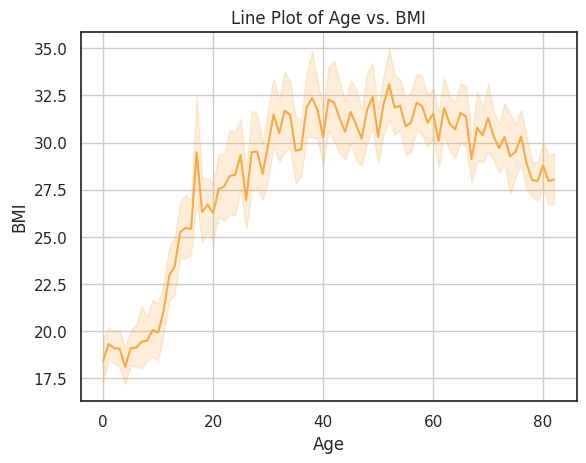

In [25]:
#line plot
sns.lineplot(x=age, y=bmi, color='#faa943')
plt.title('Line Plot of Age vs. BMI')  
plt.xlabel('Age')  
plt.ylabel('BMI')  
plt.grid(True)  
plt.show()  

### Correlation between average glucose level and bmi.

In [26]:
'''
Null Hypothesis (H0): There is no monotonic relationship between average glucose level and bmi. (ρ=0)
Alternative Hypothesis (H1): There is a monotonic relationship between average glucose level and bmi. (ρ!=0)
'''
avg_glucose_level = df['avg_glucose_level']
bmi = df['bmi']

spearman_corr, p_value = spearmanr(avg_glucose_level, bmi)

print(f"Spearman rank correlation coefficient between average glucose level and bmi: {spearman_corr}")
print(f"p-value: {p_value}")

alpha = 0.05

# evaluate
if p_value < alpha:
    print("Reject null hypothesis. There is a statistically significant monotonic relationship between average glucose level and bmi.")
else:
    print("Fail to reject null hypothesis. There is no statistically significant monotonic relationship between average glucose level and bmi.")

Spearman rank correlation coefficient between average glucose level and bmi: 0.11369630776085582
p-value: 3.580912687123695e-16
Reject null hypothesis. There is a statistically significant monotonic relationship between average glucose level and bmi.


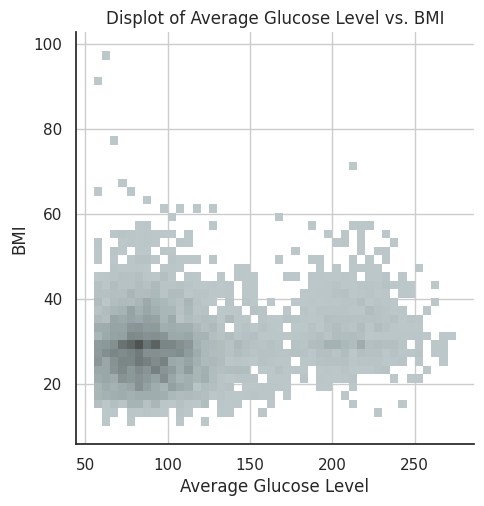

In [27]:
# displot
sns.displot(x=avg_glucose_level, y=bmi, color='#bacacb', binwidth=(5,2))
plt.title('Displot of Average Glucose Level vs. BMI')  
plt.xlabel('Average Glucose Level')  
plt.ylabel('BMI')  
plt.grid(True)  
plt.show()  

**All three analysis indicates a strong association between age, glucose levels, and BMI. These three indicators are closely related and are well-known factors in determining overall health. Given their significant interrelationship, it is crucial to consider their collective impact on stroke risk. Therefore, monitoring and managing these health metrics could be key in stroke prevention.**

## Does work type affect stroke?

In [28]:
df['work_type'].unique()

array(['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'],
      dtype=object)

In [29]:
'''
Null Hypothesis (H0): Work types have no significant effect on the likelihood of experiencing a stroke.
Alternative Hypothesis (H1): Work types have significant effect on the likelihood of experiencing a stroke.
Decide to use Chi-square test for the two categorical variables (work types and stoke).
'''
# Create a contingency table
contingency_table_work = pd.crosstab(df['work_type'], df['stroke'])
print(contingency_table_work)
chi2, p, dof, expected = stats.chi2_contingency(contingency_table_work)
alpha = 0.05
if p < alpha:
    print("Reject null hyphothesis. There is a statistically significant relationship between work types and stroke.")
else:

    print("Fail to reject null hypothesis. There is no statistically significant relationship between work types and stroke.")

stroke            0    1
work_type               
Govt_job        624   33
Never_worked     22    0
Private        2776  149
Self-employed   754   65
children        685    2
Reject null hyphothesis. There is a statistically significant relationship between work types and stroke.


stroke            0    1  Total  Stroke Rate (%)
work_type                                       
Govt_job        624   33    657         5.022831
Never_worked     22    0     22         0.000000
Private        2776  149   2925         5.094017
Self-employed   754   65    819         7.936508
children        685    2    687         0.291121


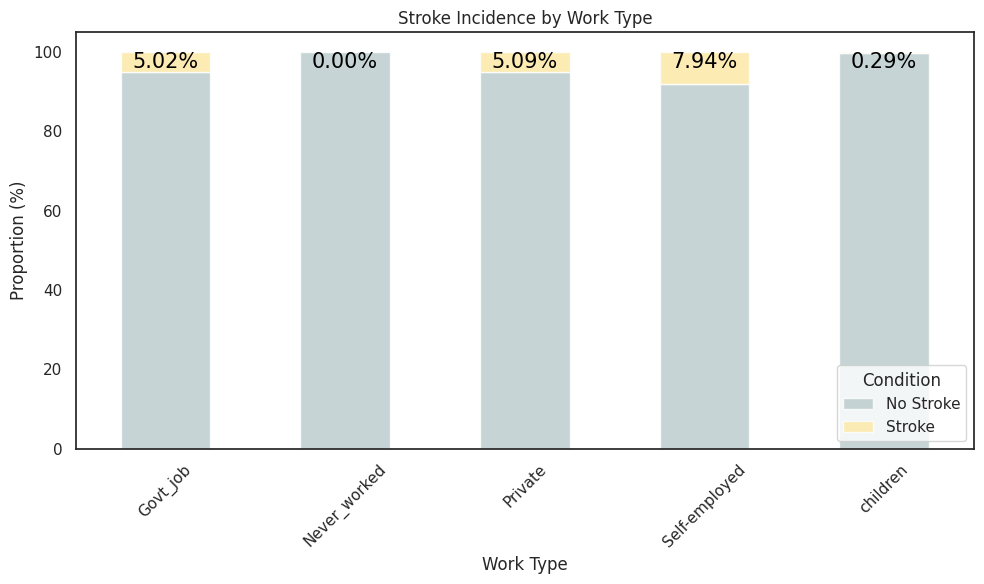

In [30]:
# calculate the stroke rate of different work types
contingency_table_work['Total'] = contingency_table_work[0] + contingency_table_work[1]
contingency_table_work['Stroke Rate (%)'] = (contingency_table_work[1]/contingency_table_work['Total']) * 100
print(contingency_table_work)

# calculate stoke and non-stroke rate
contingency_table_work['No Stroke Rate'] = (contingency_table_work[0] / contingency_table_work['Total']) * 100
contingency_table_work['Stroke Rate'] = contingency_table_work['Stroke Rate (%)']

# stacked bar plot
fig, ax = plt.subplots(figsize=(10, 6))
contingency_table_work[['No Stroke Rate', 'Stroke Rate']].plot(kind='bar', stacked=True, color=['#bacacb', '#fde7a2'], alpha=0.8, ax=ax)

# add label
for i in range(len(contingency_table_work)):
    stroke_rate = contingency_table_work.iloc[i]['Stroke Rate (%)']
    ax.text(i, 100, f'{stroke_rate:.2f}%', ha='center', va='top', color='black', fontsize=15)
plt.legend(['No Stroke', 'Stroke'], title='Condition',loc='lower right')
plt.title('Stroke Incidence by Work Type')
plt.xlabel('Work Type')
plt.ylabel('Proportion (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Self-employed people have the highest rate of experiencing stroke,childre and people never worked has lowest rate of stroke.**

## Does smoking status affect stroke?

In [31]:
# check how many types of smoking status
df['smoking_status'].unique()

array(['formerly smoked', 'never smoked', 'smokes', 'Unknown'],
      dtype=object)

In [32]:
'''
Null Hypothesis (H0): Smoking status has no significant effect on the likelihood of experiencing a stroke.
Alternative Hypothesis (H1): Smoking status has significant effect on the likelihood of experiencing a stroke.
Decide to use Chi-square test for the two categorical variables (smoking status and stoke).
'''
# Create a contingency table
contingency_table_smoke = pd.crosstab(df['smoking_status'], df['stroke'])
print(contingency_table_smoke)
chi2, p, dof, expected = stats.chi2_contingency(contingency_table_smoke)
alpha = 0.05
if p < alpha:
    print("Reject null hyphothesis. There is a statistically significant relationship between smoking status and stroke.")
else:

    print("Fail to reject null hypothesis. There is no statistically significant relationship between smoking status and stroke.")

stroke              0   1
smoking_status           
Unknown          1497  47
formerly smoked   815  70
never smoked     1802  90
smokes            747  42
Reject null hyphothesis. There is a statistically significant relationship between smoking status and stroke.


## Recommendations

Based on the comprehensive analysis, the following recommendations are proposed:

1. **Targeted Smoking Cessation Programs**: Implement programs focusing on education and support to reduce smoking rates and, consequently, the risk of stroke.

2. **Early Detection and Management of Hypertension and Heart Disease**: Early detection and effective management of these conditions are essential. Insurance policies could incentivize regular screenings and adherence to treatment plans.

3. **Weight Management Programs**: Promote weight management programs, including nutrition counseling and physical activity initiatives, to reduce obesity rates and associated stroke risks.

4. **Health Interventions for Self-Employed Individuals**: The self-employed group exhibits the highest stroke rate, possibly due to lifestyle factors or stress. Tailored health interventions, such as stress management workshops and routine health check-ups, should be considered.

5. **Health Education for Married Individuals**: Married individuals have higher stroke rates compared to their unmarried counterparts. While marital status may not be a direct risk factor, associated lifestyle factors should be addressed through health education programs focusing on risk reduction strategies.

6. **Uniform Accessibility to Health Interventions**: Since there is no significant difference in stroke rates between urban and rural areas, health interventions should be uniformly accessible to ensure that both populations receive equal care and prevention opportunities.

7. **Targeted Prevention for Older Adults**: Recommend targeted prevention strategies for older adults, including lifestyle modifications and regular medical check-ups.

## Summary of Hypothesis Testing

### 1. Does Age Affect the Incidence of Stroke?
- **Null Hypothesis (H0)**: Age does not affect the incidence of stroke.
- **Alternative Hypothesis (H1)**: Age affects the incidence of stroke.
- **Result**: We reject the null hypothesis, indicating that age is significantly associated with the likelihood of having a stroke.

### 2. Does Residence Type (City vs. Rural) Affect the Incidence of Stroke?
- **Null Hypothesis (H0)**: Residence type does not affect the incidence of stroke.
- **Alternative Hypothesis (H1)**: Residence type affects the incidence of stroke.
- **Result**: We fail to reject the null hypothesis. The residence type does not significantly affect the incidence of stroke.

### 3. Is There a Significant Relationship Between Medical History (e.g., Hypertension and Heart Disease) and the Occurrence of Stroke?
- **Null Hypothesis (H0)**: There is no significant relationship between medical history (e.g., hypertension and heart disease) and the occurrence of stroke.
- **Alternative Hypothesis (H1)**: There is a significant relationship between medical history (e.g., hypertension and heart disease) and the occurrence of stroke.
- **Results**:
  - Hypertension: Reject the null hypothesis. There is a statistically significant relationship between hypertension and stroke.
  - Heart Disease: Reject the null hypothesis. There is a statistically significant relationship between heart disease and stroke.
  - Both Conditions: Reject the null hypothesis. There is a statistically significant relationship between having both conditions and stroke.

### 4. What Are the Spearman Rank Correlation Coefficients Between Age, Average Glucose Level, and BMI?
#### Correlation between age and average glucose level.
- **Null Hypothesis (H0)**: There is no monotonic relationship between age and average glucose level. (ρ=0)
- **Alternative Hypothesis (H1)**: There is a monotonic relationship between age and average glucose level. (ρ!=0)
- **Results**:
- Reject null hypothesis. There is a statistically significant monotonic relationship between age and average glucose level.
#### Correlation between age and bmi.
- **Null Hypothesis (H0)**: There is no monotonic relationship between age and bmi. (ρ=0)
- **Alternative Hypothesis (H1)**: There is a monotonic relationship between age and bmi. (ρ!=0)
-  **Results**:
- Reject null hypothesis. There is a statistically significant monotonic relationship between age and bmi.
#### Correlation between average glucose level and bmi.
- **Null Hypothesis (H0)**: There is no monotonic relationship between average glucose level and bmi. (ρ=0)
- **Alternative Hypothesis (H1)**: There is a monotonic relationship between average glucose level and bmi. (ρ!=0)
- **Results**:
- Reject null hypothesis. There is a statistically significant monotonic relationship between average glucose level and bmi.

### 5. Does Work Type Affect the Incidence of Stroke?
- **Null Hypothesis (H0)**: Work type has no significant effect on the likelihood of experiencing a stroke.
- **Alternative Hypothesis (H1)**: Work type has a significant effect on the likelihood of experiencing a stroke.
- **Result**: We reject the null hypothesis. There is a statistically significant relationship between work type and stroke.

### 6. Does Smoking Status Affect the Incidence of Stroke?
- **Null Hypothesis (H0)**: Smoking status has no significant effect on the likelihood of experiencing a stroke.
- **Alternative Hypothesis (H1)**: Smoking status has a significant effect on the likelihood of experiencing a stroke.
- **Result**: We reject the null hypothesis. There is a statistically significant relationship between smoking status and stroke.